### **Anomaly detection on CPU usage**

Anomaly Detection means to identify unexpected events in a process. It means to detect threats to our systems that may cause harm in terms of security and leakage of important information, but the importance of Anomaly Detection is not limited to security. The data of this project is based on per-minute metrics of the host’s CPU utilization.

In [1]:
%%capture

!pip install -r ../requirements.txt

In [157]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [4]:
url_train_a = 'https://raw.githubusercontent.com/oreilly-mlsec/book-resources/master/chapter3/datasets/cpu-utilization/cpu-train-a.csv'
url_train_b = 'https://raw.githubusercontent.com/oreilly-mlsec/book-resources/master/chapter3/datasets/cpu-utilization/cpu-train-b.csv'
url_test_a = 'https://raw.githubusercontent.com/oreilly-mlsec/book-resources/master/chapter3/datasets/cpu-utilization/cpu-test-a.csv'
url_test_b = 'https://raw.githubusercontent.com/oreilly-mlsec/book-resources/master/chapter3/datasets/cpu-utilization/cpu-test-b.csv'

df_train_a = pd.read_csv(url_train_a)
df_train_b = pd.read_csv(url_train_b)
df_test_a = pd.read_csv(url_test_a)
df_test_b = pd.read_csv(url_test_b)

df_train_a.to_csv('../data/raw/train_a.csv')
df_train_b.to_csv('../data/raw/train_b.csv')
df_test_a.to_csv('../data/raw/test_a.csv')
df_test_b.to_csv('../data/raw/test_b.csv')

### Dataset a

In [20]:
df_train_a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420 entries, 0 to 419
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   datetime  420 non-null    object 
 1   cpu       420 non-null    float64
dtypes: float64(1), object(1)
memory usage: 6.7+ KB


In [5]:
df_train_a.sample(5)

,datetime,cpu
341,2017-01-28 00:23:00,0.68
49,2017-01-27 19:31:00,0.61
174,2017-01-27 21:36:00,0.79
50,2017-01-27 19:32:00,0.61
218,2017-01-27 22:20:00,0.82


In [13]:
df_train_a.describe()

,cpu
count,420.000000
mean,1.233262
std,0.505668
min,0.570000
25%,0.787500
50%,1.110000
75%,1.582500
max,2.550000


In [5]:
df_train_a.duplicated().sum()

0

In [6]:
def preprocessing(df):
    df['datetime'] = pd.to_datetime(df['datetime'])
    df = df.set_index(df['datetime'])
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['hour'] = df.index.hour
    df['minute'] = df.index.minute
    df = df.drop(['datetime'], axis=1)
    return df

In [7]:
df_train_a = preprocessing(df_train_a)
df_train_a.to_csv('../data/processed/df_train_a_processed.csv')

In [8]:
df_train_a.head(5)

,cpu,year,month,day,hour,minute
datetime,,,,,,
2017-01-27 18:42:00,1.14,2017,1,27,18,42
2017-01-27 18:43:00,1.10,2017,1,27,18,43
2017-01-27 18:44:00,1.09,2017,1,27,18,44
2017-01-27 18:45:00,1.08,2017,1,27,18,45
2017-01-27 18:46:00,1.08,2017,1,27,18,46


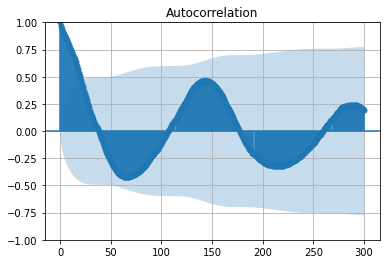

In [9]:
plot_acf(df_train_a['cpu'].values, lags=300)
plt.grid()
plt.show()

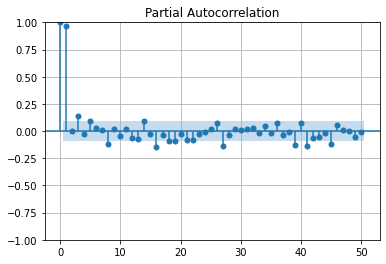

In [27]:
plot_pacf(df_train_a['cpu'].values, lags=50)
plt.grid()
plt.show()

In [168]:
res = seasonal_decompose(df_train_a['cpu'].values, period=144)

res_observed = res.observed
res_trend = res.trend
res_seasonal = res.seasonal
res_residual = res.resid

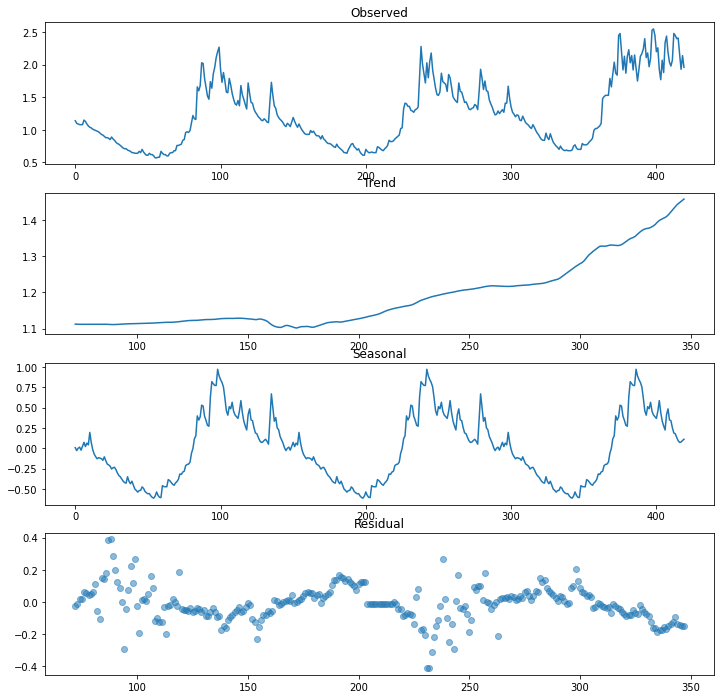

In [169]:
fig, ax = plt.subplots(4, figsize=(12, 12))

ax[0].set_title('Observed')
ax[0].plot(res_observed)

ax[1].set_title('Trend')
ax[1].plot(res_trend)

ax[2].set_title('Seasonal')
ax[2].plot(res_seasonal)

ax[3].set_title('Residual')
ax[3].scatter(y=res_residual, x=range(len(res_residual)), alpha=0.5)

plt.show()

In [31]:
df_test_a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   datetime  60 non-null     object 
 1   cpu       60 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.1+ KB


In [12]:
df_test_a = preprocessing(df_test_a)
df_test_a.to_csv('../data/processed/df_test_a_processed.csv')

In [151]:
model = ARIMA(df_train_a['cpu'], order=(8, 0, 25))

/home/gitpod/.pyenv/versions/3.8.13/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)
/home/gitpod/.pyenv/versions/3.8.13/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)
/home/gitpod/.pyenv/versions/3.8.13/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)


In [152]:
res = model.fit()

/home/gitpod/.pyenv/versions/3.8.13/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/gitpod/.pyenv/versions/3.8.13/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [153]:
y_pred_train_a = pd.Series(res.fittedvalues, copy=True)

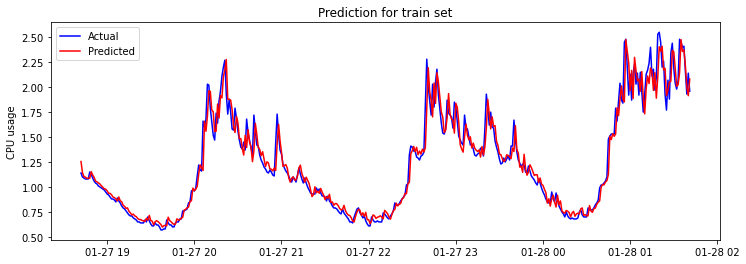

In [154]:
plt.figure(figsize=(12,4))
plt.plot(df_train_a['cpu'], color='Blue', label='Actual')
plt.plot(y_pred_train_a, color='Red', label='Predicted')
plt.ylabel('CPU usage')
plt.title('Prediction for train set')
plt.legend()
plt.show()

In [155]:
y_pred_test_a = res.predict(start='2017-01-28 01:42:00', end='2017-01-28 02:41:00')

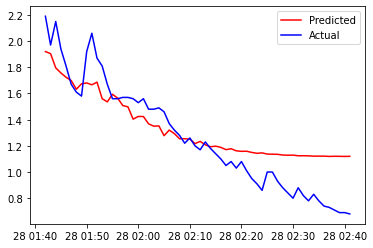

In [156]:
plt.plot(y_pred_test_a, color='Red', label='Predicted')
plt.plot(df_test_a['cpu'], color='Blue', label='Actual')
plt.legend()
plt.show()

In [175]:
model_2 = SARIMAX(endog=df_train_a['cpu'], order=(8,0,25), seasonal_order=(1,0,0,144))

/home/gitpod/.pyenv/versions/3.8.13/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)
/home/gitpod/.pyenv/versions/3.8.13/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)


In [176]:
res_2 = model_2.fit()

/home/gitpod/.pyenv/versions/3.8.13/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           35     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.20290D-01    |proj g|=  9.53887D-01


 This problem is unconstrained.



At iterate    5    f= -7.25510D-01    |proj g|=  3.18274D-01

At iterate   10    f= -7.27525D-01    |proj g|=  1.23751D-01

At iterate   15    f= -7.28278D-01    |proj g|=  7.09473D-02

At iterate   20    f= -7.28722D-01    |proj g|=  2.03081D-02

At iterate   25    f= -7.29193D-01    |proj g|=  7.31263D-02

At iterate   30    f= -7.31386D-01    |proj g|=  5.22794D-02

At iterate   35    f= -7.32830D-01    |proj g|=  4.74119D-02

At iterate   40    f= -7.34111D-01    |proj g|=  1.45699D-02

At iterate   45    f= -7.35246D-01    |proj g|=  9.62419D-02


/home/gitpod/.pyenv/versions/3.8.13/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -7.35799D-01    |proj g|=  1.42428D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   35     50     60      1     0     0   1.424D-02  -7.358D-01
  F = -0.73579912152356852     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


In [177]:
y_pred_test_a_2 = res_2.predict(start='2017-01-28 01:42:00', end='2017-01-28 02:41:00')

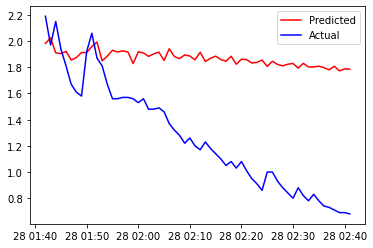

In [178]:
plt.plot(y_pred_test_a_2, color='Red', label='Predicted')
plt.plot(df_test_a['cpu'], color='Blue', label='Actual')
plt.legend()
plt.show()

### Dataset b

In [33]:
df_train_b.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   datetime  600 non-null    object 
 1   cpu       600 non-null    float64
dtypes: float64(1), object(1)
memory usage: 9.5+ KB


In [34]:
df_train_b.sample(5)

,datetime,cpu
60,2017-01-27 19:42:00,0.64
410,2017-01-28 01:32:00,1.98
519,2017-01-28 03:21:00,1.51
283,2017-01-27 23:25:00,1.60
204,2017-01-27 22:06:00,0.66


In [35]:
df_train_b.describe()

,cpu
count,600.000000
mean,1.282733
std,0.484951
min,0.570000
25%,0.840000
50%,1.240000
75%,1.610000
max,2.550000


In [13]:
df_train_b.duplicated().sum()

0

In [14]:
df_train_b = preprocessing(df_train_b)
df_train_b.to_csv('../data/processed/df_train_b_processed.csv')

In [39]:
df_train_b.head(5)

,cpu,year,month,day,hour,minute
datetime,,,,,,
2017-01-27 18:42:00,1.14,2017,1,27,18,42
2017-01-27 18:43:00,1.10,2017,1,27,18,43
2017-01-27 18:44:00,1.09,2017,1,27,18,44
2017-01-27 18:45:00,1.08,2017,1,27,18,45
2017-01-27 18:46:00,1.08,2017,1,27,18,46


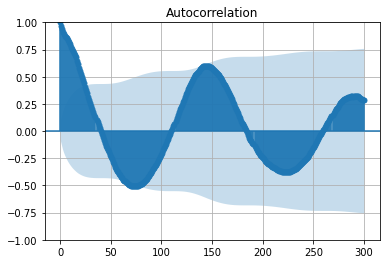

In [15]:
plot_acf(df_train_b['cpu'].values, lags=300)
plt.grid()
plt.show()

In [164]:
res_b = seasonal_decompose(df_train_b['cpu'].values, period=144)

res_observed_b = res_b.observed
res_trend_b = res_b.trend
res_seasonal_b = res_b.seasonal
res_residual_b = res_b.resid

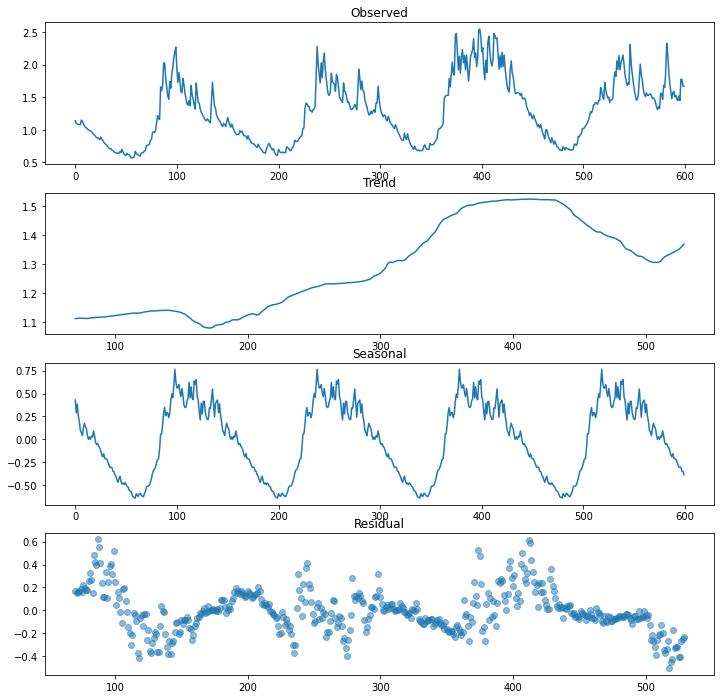

In [165]:
fig, ax = plt.subplots(4, figsize=(12, 12))

ax[0].set_title('Observed')
ax[0].plot(res_observed_b)

ax[1].set_title('Trend')
ax[1].plot(res_trend_b)

ax[2].set_title('Seasonal')
ax[2].plot(res_seasonal_b)

ax[3].set_title('Residual')
ax[3].scatter(y=res_residual_b, x=range(len(res_residual_b)), alpha=0.5)

plt.show()

In [18]:
df_test_b.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   datetime  60 non-null     object 
 1   cpu       60 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.1+ KB


In [19]:
df_test_b = preprocessing(df_test_b)
df_test_b.to_csv('../data/processed/df_test_b_processed.csv')